In [1672]:
import os
import warnings

import pandas as pd
import numpy as np


from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
)
from jre_utils.config import asset_types
from jp_prefecture.jp_cities import JpCity, jp_cities
from geopy.geocoders import Nominatim

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [1673]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)


def map_time_units(x):
    mapping = {
        "30-60minutes": 45,
        "1H-1H30": 75,
        "1H30-2H": 105,
        "2H-": 135,
    }
    
    return int(x) if x.isdigit() else mapping[x]

def map_layout(x):
    if x == "na":
        return "na"

    x = x.split("+")[0]

    if x[0].isdigit() and int(x[0]) == 1:
        if x != "1K" and x != "1LDK" and x != "1DK":
            return "1other"
        return x
    
    if x[0].isdigit() and int(x[0]) == 2:
        if x != "2LDK" and x != "2DK":
            return "2other"
        return x

    if x[0].isdigit() and int(x[0]) > 2:
        return f"{min(int(x[0]), 5)}LDK"
    
    return "other"

def map_land_shape(x):
    x = x.lower()
    x = x.replace("semi-", "")
    return x

def map_frontage(x):
    if x == "na":
        return 0
    if x == "50.0m or longer.":
        return 55
    return int(x.split(".")[0])

def map_floor_area(x):
    if "less" in x:
        return 10
    elif "greater" in x:
        return 2000
    else:
        return int(x)
    
def map_year_of_construction(x):
    if x == "before the war":
        return 1930
    
    return int(x)

In [1674]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city['1101']}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area['1100']}") 

def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

def get_city_geocode(area_code):
    area_code = str(area_code)
    try:
        return tuple(jp_cities.citycode2geodetic(area_code)) 
    except:
        print(f"Could not find geocode for {area_code}")
        return np.NaN, np.NaN
    
def find_town_jp(all_towns_df, city_code, town_name, log=False):
    city_df = all_towns_df[all_towns_df["cityCode"] == int(city_code)]
    town_df = city_df[city_df["townAlphabet"].str.contains(town_name)]
    
    if town_df.empty:
        if log:
            print(f"JP could not find {town_name} in {city_code}")
        return None, None
    
    return town_df["longitude"].mean(), town_df["latitude"].mean()

def find_town_geopy(geolocator, address, log=False):
    location_info = geolocator.geocode(address)

    if not location_info:
        if log:
            print(f"Geopy could not find {address}")
        return None, None
    
    return location_info.longitude, location_info.latitude

def get_town_coordinates_jp(all_towns_df, city_name, city_code, town_name, log=False):
    geolocator = Nominatim(user_agent="my_app")
    
    # Try to locade in df - this is fast
    jp_lon, jp_lat = find_town_jp(all_towns_df, city_code, town_name, log)

    if not jp_lon or not jp_lat:
        address = f"{town_name}, {city_name}, Japan"
        
        # Fall back and try to locate with geopy - this is slow
        geopy_lon, geopy_lat = find_town_geopy(geolocator, address, log)
        
        if not geopy_lon or not geopy_lat:
            # if nothing works, just return the city coordinates
            return get_city_geocode(city_code)
        
        return geopy_lon, geopy_lat

    return jp_lon, jp_lat



'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [1675]:
prefecture_code = 13
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in sorted(os.listdir(trade_prices_data_path))
]
trade_prices_data_paths[prefecture_code - 1]

'../../data/core/13_Tokyo_20053_20233.csv'

In [1788]:
df = pd.read_csv(
    trade_prices_data_paths[prefecture_code - 1],
    encoding="unicode_escape",
    index_col="No",
)
df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

# we may want to skip the following step in the future
df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
df["area"] = df["area_code"].apply(get_area_from_area_code)

df["trade_price"] = df["Transaction-price(total)"]
df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
df["unit_price"] = df["Transaction-price(Unit price m^2)"]
df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

df["unit_price"] = np.where(
    df["unit_price"].isna(),
    df["trade_price_per_area"],
    df["unit_price"],
)

df = df[
    df["Type"].isin(
        [
            asset_types["building"]["label"],
            asset_types["land"]["label"],
            asset_types["condo"]["label"],
        ],
    )
]

# Renaming

df = df.rename(columns = {
    "Type": "asset_type",
    "Region": "neighbourhood_classification",
    "Area": "subarea",
    "Nearest stationFName": "nearest_station",
    "Nearest stationFDistance(minute)": "time_to_nearest_station",
    "Layout": "layout",
    "Land shape": "land_shape",
    "Frontage": "frontage",
    "Total floor area(m^2)": "total_floor_area",
    "Year of construction": "year_of_construction",
    "Building structure": "building_structure",
    "Use": "use",
    "Purpose of Use": "purpose",
    "Frontage roadFDirection": "frontage_road_direction",
    "Frontage roadFClassification": "frontage_road_classification",
    "Frontage roadFBreadth(m)": "frontage_road_breadth",
    "City Planning": "zone",
    "Maximus Building Coverage Ratio(%)": "max_building_coverage_ratio",
    "Maximus Floor-area Ratio(%)": "max_floor_area_ratio",
    "Renovation": "renovation_status",
    "Transactional factors": "transactional_factors", # need to format and include
})

# Process factors

df["subarea"] = df["subarea"].fillna("")
df["neighbourhood_classification"] = df["neighbourhood_classification"].fillna("na")
df["nearest_station"] = df["nearest_station"].fillna("na")
df["time_to_nearest_station"] = df["time_to_nearest_station"].fillna("30-60minutes").apply(map_time_units)
df["layout"] = df["layout"].fillna("na").apply(map_layout)
df["land_shape"] = df["land_shape"].fillna("na").map(map_land_shape)
df["frontage"] = df["frontage"].fillna("na").apply(map_frontage)

df["total_floor_area"] = np.where(
    df["total_floor_area"].isna(),
    df["trade_area"].astype(str),
    df["total_floor_area"],
)

df["total_floor_area"] = df["total_floor_area"].apply(map_floor_area)


df["year_of_construction"] = np.where(
    df["year_of_construction"].isna(),
    (df["year"] - 30).astype(str),
    df["year_of_construction"],
)

df["year_of_construction"] = df["year_of_construction"].apply(map_year_of_construction)
df["age"] = (df["year"] - df["year_of_construction"]).apply(lambda x: max(x, 0))

df["building_structure"] = df["building_structure"].fillna("na")
df["frontage_road_direction"] = df["frontage_road_direction"].fillna("na")
df["frontage_road_classification"] = df["frontage_road_classification"].fillna("na")
df["frontage_road_breadth"] = df["frontage_road_breadth"].fillna("0.0").astype(float)
df["zone"] = df["zone"].fillna("na")
df["max_building_coverage_ratio"] = df["max_building_coverage_ratio"].fillna(0)
df["max_floor_area_ratio"] = df["max_floor_area_ratio"].fillna(0)
df["renovation_status"] = df["renovation_status"].fillna("na")


df["use"] = df["use"].fillna("na")
df["purpose"] = df["purpose"].fillna("na")
df["transactional_factors"] = df["transactional_factors"].fillna("na")

df = df.drop(columns = [
    "City,Town,Ward,Village code",
    "City,Town,Ward,Village",
    "Transaction-price(total)",
    "Area(m^2)",
    "Transaction-price(Unit price m^2)",
    "trade_price_per_area",
    "Transaction period",
    "Prefecture",
])

In [ ]:
# Convert towns into Longitude and Latitude
jp_towns = JpCity(enable_town=True)
towns_df = jp_towns.towns
towns_df["townAlphabet"] = towns_df["townAlphabet"].fillna("")

towns_list_df = df[["area", "area_code", "subarea"]].drop_duplicates()
towns_list_df[["long", "lat"]] = towns_list_df.apply(
    lambda x: pd.Series(get_town_coordinates_jp(towns_df, x["area"], x["area_code"], x["subarea"])),
    axis=1,
)

In [1789]:
# Advanced preprocessing
df = df.merge(towns_list_df, on=["area", "area_code", "subarea"], how="left")


In [1790]:
land_df = df[df["asset_type"] == asset_types["land"]["label"]]
building_df = df[df["asset_type"] == asset_types["building"]["label"]]
condo_df = df[df["asset_type"] == asset_types["condo"]["label"]]

dfs_dict = {
    "land": land_df,
    "building": building_df,
    "condo": condo_df
}

In [1811]:
id_columns = ["year"]
metric_columns = ["unit_price_log"]

# land_df.info()

land_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "transactional_factors",
    ],
}

# building_df.info()

building_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "total_floor_area",
        "trade_area",
        "age",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

# condo_df.info()

condo_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "age",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "renovation_status",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

columns_dicts = {
    "land": land_columns,
    "building": building_columns,
    "condo": condo_columns
}

In [1813]:
area_code = "13107"
asset_type = "building"
asset_df = dfs_dict[asset_type]
columns_dict = columns_dicts[asset_type]

numerical_columns = columns_dict["numerical_columns"]
categorical_columns = columns_dict["categorical_columns"]
comma_separated_categorical_columns = columns_dict["comma_separated_categorical_columns"]
all_unprocessed_columns = numerical_columns + categorical_columns + comma_separated_categorical_columns

In [1826]:
area_df = asset_df[asset_df["area_code"] == area_code].reset_index(drop=True)

area_df["year"] = area_df["year"].astype(str)
area_df["quarter"] = area_df["quarter"].astype(str)
area_df[f"unit_price_log"] = np.log(area_df["unit_price"] + 1)


for column in numerical_columns:
    area_df[column] = np.log(area_df[column] + 1)

# Scale numerical variables
scaler = StandardScaler()
area_df[numerical_columns] = scaler.fit_transform(area_df[numerical_columns])

# Categorical variables
area_df = pd.get_dummies(
    area_df[all_unprocessed_columns + id_columns + metric_columns], columns=categorical_columns
)

# Comma Separated Categorical variables
for column in comma_separated_categorical_columns:
    one_hot_df = (
        area_df[column]
        .str.replace(" ", "")
        .str.get_dummies(sep=",")
        .rename(columns=lambda x: column + x)
    )
    area_df = pd.concat([area_df, one_hot_df], axis=1)
    area_df = area_df.drop(columns=[column])

drop_columns = [col for col in area_df.columns if "na" in col]
area_df = area_df.drop(columns=drop_columns)
area_df

,long,lat,time_to_nearest_station,total_floor_area,trade_area,age,frontage,frontage_road_breadth,max_building_coverage_ratio,max_floor_area_ratio,year,unit_price_log,neighbourhood_classification_Commercial Area,neighbourhood_classification_Industrial Area,neighbourhood_classification_Residential Area,quarter_1,quarter_2,quarter_3,quarter_4,zone_Category I Residential Zone,zone_Commercial Zone,zone_Industrial Zone,zone_Neighborhood Commercial Zone,zone_Quasi-industrial Zone,purpose_Factory,purpose_House,purpose_Office,purpose_Other,purpose_Shop,purpose_Warehouse,land_shape_&quot;flag-shaped&quot; etc.,land_shape_irregular shaped,land_shape_rectangular shaped,land_shape_shaped,land_shape_square shaped,land_shape_trapezoidal shaped,frontage_road_direction_East,frontage_road_direction_No facing road,frontage_road_direction_North,frontage_road_direction_Northeast,frontage_road_direction_Northwest,frontage_road_direction_South,frontage_road_direction_Southeast,frontage_road_direction_Southwest,frontage_road_direction_West,frontage_road_classification_Access Road,frontage_road_classification_City Road,frontage_road_classification_Forest Road,frontage_road_classification_Hokkaido Prefectural Road,frontage_road_classification_Private Road,frontage_road_classification_Road,frontage_road_classification_Tokyo Metropolitan Road,frontage_road_classification_Ward Road,useFactory,useHouse,useHousingComplex,useOffice,useOther,useParkingLot,useShop,useWarehouse,useWorkshop,building_structureB,building_structureLS,building_structureRC,building_structureS,building_structureSRC,building_structureW
0,-1.220003,-0.285964,-0.720109,1.053221,-0.371234,-0.088190,-0.229124,2.555170,0.241478,1.168743,2022,15.270798,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,-1.220003,-0.285964,-0.720109,0.309297,1.014387,0.738161,0.979128,0.009732,0.241478,0.147367,2022,13.988783,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.220003,-0.285964,-0.720109,2.856257,2.748932,0.556063,2.481510,2.555170,0.241478,1.168743,2021,13.377257,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
3,-1.220003,-0.285964,-1.225737,0.339056,0.395784,1.130764,1.202749,1.574989,0.241478,1.168743,2019,13.549809,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,-1.220003,-0.285964,-0.306982,0.111977,-0.371234,-0.933909,-0.514035,0.864350,0.241478,0.147367,2023,14.865333,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,-2.186430,-1.562180,-0.306982,2.401703,1.555896,0.334670,1.572150,0.877827,0.241478,1.168743,2007,14.527007,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2871,-2.186430,-1.562180,-0.720109,2.041293,0.761323,0.207998,0.718075,2.123110,0.241478,1.168743,2006,14.475868,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
2872,-2.186430,-1.562180,-1.225737,1.351607,2.189689,0.528945,0.979128,0.877827,0.241478,1.168743,2006,13.213337,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2873,-2.186430,-1.562180,-0.720109,1.327532,1.501800,-0.511050,1.303602,0.877827,0.241478,1.168743,2005,13.776291,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [1827]:
X_ord = area_df.drop(columns=id_columns + metric_columns)

In [1839]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=0.90)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_ord)

# Print the number of components retained by PCA
print("Number of components retained by PCA:", pca.n_components_)
print(X_pca.shape)

Number of components retained by PCA: 22
(2875, 22)


In [1850]:
yearly_df = area_df[id_columns + metric_columns]
yearly_df = pd.get_dummies(yearly_df, columns=id_columns)
yearly_df = pd.concat(
    [
        yearly_df,
        pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)]),
    ],
    axis=1,
)
yearly_df

,unit_price_log,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
0,15.270798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.643323,-1.285131,0.580760,0.121494,1.040980,1.637924,-0.561482,0.702193,0.664936,0.990835,-0.858853,0.271253,-0.018571,0.868412,0.624057,0.413393,0.233664,-0.647214,-0.312753,0.093603,-0.472505,0.206684
1,13.988783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.921007,0.139600,0.044942,-0.815480,-0.427756,-0.405060,-0.065380,0.812828,-0.538457,-0.329162,0.839276,0.166632,0.183983,1.174094,0.802968,-0.017197,-0.048952,0.621772,0.291939,0.202139,-0.444751,0.334387
2,13.377257,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.424775,0.769004,-1.771853,-0.662835,0.360248,1.001218,-0.767975,0.465731,1.252460,-0.327575,-0.011596,-0.049335,0.758943,-0.283839,-0.510400,0.143626,0.413183,-0.611904,-0.335271,0.119043,-0.598450,0.082875
3,13.549809,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.992567,-0.862873,0.324922,-1.014431,-0.491064,1.026157,-0.957111,0.400708,0.946815,-0.500345,0.277439,-0.122750,0.316167,0.352403,-0.550127,0.733879,-0.550888,0.200941,-0.282338,-0.012400,0.216507,-0.356307
4,14.865333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.885038,-0.782972,0.752881,0.272754,1.160273,0.361616,-0.352332,0.977636,-0.738923,0.343850,0.184757,-0.116582,0.516006,0.176721,0.972785,0.212035,-0.791435,-0.312680,0.753976,-0.565049,0.010645,0.405618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,14.527007,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.279810,0.206548,-0.058550,0.099406,0.602669,-1.241005,-0.011727,0.244921,0.467107,-0.390099,-0.113572,0.422415,0.032067,-1.030073,0.229455,-0.732870,0.652593,0.866041,-0.245341,-0.126550,0.004872,-0.562419
2871,14.475868,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.398861,-0.509460,0.423806,0.057745,1.232852,0.550330,-0.048832,0.510774,1.041393,-0.126360,0.151838,0.502048,-0.527758,-0.199966,0.006663,0.418898,-0.575100,-0.037044,0.274275,-0.813152,0.236785,-0.350114
2872,13.213337,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.349332,-0.106307,0.323788,-0.775732,0.577973,-0.703016,0.343524,0.523457,0.071988,0.076896,0.204507,-0.039332,0.308977,0.044040,0.717021,0.150184,0.068379,-0.474186,-0.027354,0.717306,0.780216,0.990957
2873,13.776291,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.780351,-0.374728,0.315239,-0.033594,1.163495,-0.778209,-0.559372,0.460350,0.128054,-0.160547,0.556608,-0.825958,0.003800,-0.571883,-0.100095,-0.591388,0.654528,-0.503943,-0.000408,-0.846493,0.421062,0.626783


In [1841]:
X = yearly_df.drop(columns=metric_columns)
y = yearly_df[metric_columns[0]]

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the OLS model
ordinary_results = sm.OLS(y, X).fit()
print(ordinary_results.summary())

                            OLS Regression Results                            
Dep. Variable:         unit_price_log   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     141.5
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:22:52   Log-Likelihood:                -1429.0
No. Observations:                2875   AIC:                             2940.
Df Residuals:                    2834   BIC:                             3185.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6786      0.007   1698.123      0.0

In [1842]:
# Create an RLM model object
robust_model = sm.RLM(y, X)

# Fit the model
robust_results = robust_model.fit()

# Print out the summary of the regression results
print(robust_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:         unit_price_log   No. Observations:                 2875
Model:                            RLM   Df Residuals:                     2834
Method:                          IRLS   Df Model:                           40
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 29 Mar 2024                                         
Time:                        13:22:53                                         
No. Iterations:                    24                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6811      0.006   2007.169      0.0

In [1844]:
robust_results_df = get_price_index_from_regression(robust_results)
robust_results_df

,year,price_index,p_value
0,2005,0.4769,0.0
1,2006,0.5041,0.0
2,2007,0.6637,0.0
3,2008,0.5562,0.0
4,2009,0.4153,0.0
5,2010,0.4870,0.0
6,2011,0.4760,0.0
7,2012,0.4647,0.0
8,2013,0.4833,0.0
9,2014,0.5379,0.0


In [1845]:
ordinary_results_df = get_price_index_from_regression(ordinary_results)
ordinary_results_df

,year,price_index,p_value
0,2005,0.4814,0.0
1,2006,0.4953,0.0
2,2007,0.6628,0.0
3,2008,0.5267,0.0
4,2009,0.4373,0.0
5,2010,0.5142,0.0
6,2011,0.4749,0.0
7,2012,0.4507,0.0
8,2013,0.4534,0.0
9,2014,0.5337,0.0


<Axes: xlabel='year'>

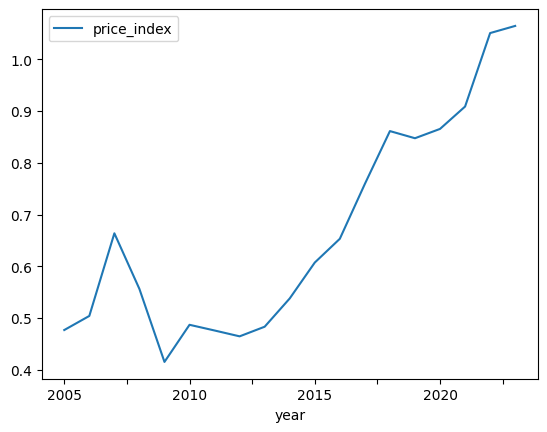

In [1846]:
robust_results_df.plot.line(y="price_index", x="year")

<Axes: xlabel='year'>

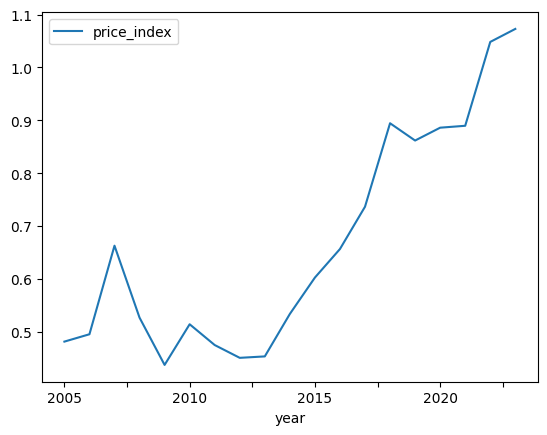

In [1847]:
ordinary_results_df.plot.line(y="price_index", x="year")

<Axes: xlabel='year'>

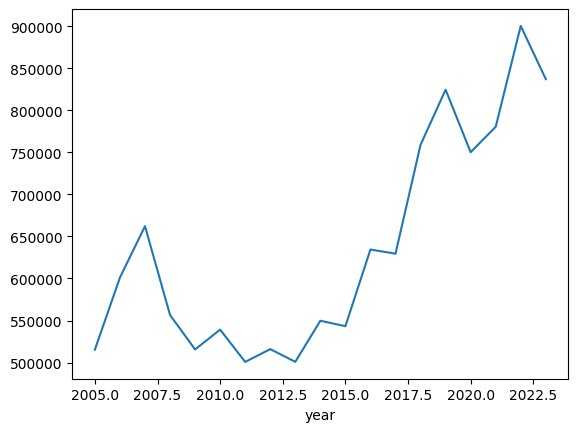

In [1848]:
area_df_2 = asset_df[asset_df["area_code"] == area_code].reset_index(drop=True)
area_df_2.groupby(['year'])['unit_price'].apply(lambda x: np.exp(np.log(x).mean())).plot.line()

In [ ]:
def get_price_index_from_regression(regression_results):
    yearly_results = regression_results.params.filter(like='year_')
    yearly_p_value = regression_results.pvalues.filter(like='year_')

    yearly_results.name = "price_index"
    yearly_p_value.name = "p_value"

    results_df = pd.concat([yearly_results, yearly_p_value], axis=1).round(4)
    results_df = results_df.reset_index().rename(columns={"index": "year"})
    results_df["year"] = results_df["year"].apply(lambda x: x.split("_")[1])
    return results_df


def calculate_price_index(area_df, columns_dict):
    numerical_columns = columns_dict["numerical_columns"]
    categorical_columns = columns_dict["categorical_columns"]
    comma_separated_categorical_columns = columns_dict["comma_separated_categorical_columns"]
    all_unprocessed_columns = numerical_columns + categorical_columns + comma_separated_categorical_columns

    area_df["year"] = area_df["year"].astype(str)
    area_df["quarter"] = area_df["quarter"].astype(str)
    area_df[f"unit_price_log"] = np.log(area_df["unit_price"] + 1)
    
    # Numerical variables
    scaler = StandardScaler()

    for column in numerical_columns:
        area_df[column] = np.log(area_df[column] + 1)

    area_df[numerical_columns] = scaler.fit_transform(area_df[numerical_columns])

    # Categorical variables
    area_df = pd.get_dummies(
        area_df[all_unprocessed_columns + id_columns + metric_columns], columns=categorical_columns
    )

    # Comma Separated Categorical variables
    for column in comma_separated_categorical_columns:
        one_hot_df = (
            area_df[column]
            .str.replace(" ", "")
            .str.get_dummies(sep=",")
            .rename(columns=lambda x: column + x)
        )
        area_df = pd.concat([area_df, one_hot_df], axis=1)
        area_df = area_df.drop(columns=[column])

    drop_columns = [col for col in area_df.columns if "na" in col]
    area_df = area_df.drop(columns=drop_columns)

    # Model
    X_ord = area_df.drop(columns=id_columns + metric_columns)

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=0.90)  # Retain p% of the variance
    X_pca = pca.fit_transform(X_ord)

    # Expand years
    yearly_df = area_df[id_columns + metric_columns]
    yearly_df = pd.get_dummies(yearly_df, columns=id_columns)
    yearly_df = pd.concat(
        [
            yearly_df,
            pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)]),
        ],
        axis=1,
    )

    X = yearly_df.drop(columns=metric_columns)
    y = yearly_df[metric_columns[0]]

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Fit the OLS model
    ordinary_results = sm.OLS(y, X).fit()
    robust_results = sm.RLM(y, X).fit()

    # Compile results
    ordinary_results_df = get_price_index_from_regression(ordinary_results)
    robust_results_df = get_price_index_from_regression(robust_results)

    return ordinary_results_df, robust_results_df

    